# Training a Digit Classifier

In [16]:
from pathlib import Path

import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
from PIL import Image

plt.rcParams["image.cmap"] = "gray"

In [2]:
mnist_path = Path("~/.fastai/data/mnist_sample/").expanduser()

In [3]:
if not mnist_path.exists():
    import fastbook

    fastbook.untar_data(fastbook.URLs.MNIST_SAMPLE)

In [4]:
threes = list(mnist_path.glob("train/3/*.png"))
sevens = list(mnist_path.glob("train/7/*.png"))

In [5]:
len(threes), len(sevens)

(6131, 6265)

In [6]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [7]:
jnp.array(im3)[4:9, 4:9]

DeviceArray([[  0,   4, 104, 141, 191],
             [  0, 104, 252, 252, 252],
             [  0, 104, 252, 252, 214],
             [  0,  16, 139,  52,  15],
             [  0,   0,   0,   0,   0]], dtype=uint8)

Generally, when images are floats, the pixel values are expected to be between 0 and 1,
so we will also divide by 255 here

In [8]:
stacked_threes = jnp.stack([jnp.array(Image.open(p)) for p in threes]) / 255
stacked_sevens = jnp.stack([jnp.array(Image.open(p)) for p in sevens]) / 255
stacked_threes.shape, stacked_sevens.shape

((6131, 28, 28), (6265, 28, 28))

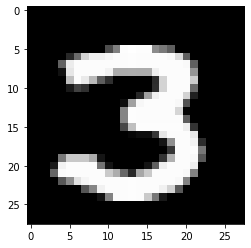

In [9]:
plt.imshow(stacked_threes[0])

In [15]:
valid_3s = (
    jnp.stack([jnp.array(Image.open(p)) for p in mnist_path.glob("valid/3/*.png")])
    / 255
)
valid_7s = (
    jnp.stack([jnp.array(Image.open(p)) for p in mnist_path.glob("valid/7/*.png")])
    / 255
)

### Comparing with the perfect 3 and 7

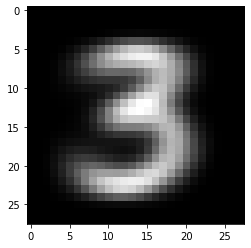

In [10]:
mean_3 = jnp.mean(stacked_threes, axis=0)
plt.imshow(mean_3)

In [11]:
mean_3[4:9, 4:9]

DeviceArray([[0.00139951, 0.00578545, 0.01366377, 0.0301112 , 0.05540087],
             [0.00889085, 0.02783732, 0.06106351, 0.11270592, 0.1868844 ],
             [0.02449845, 0.05989939, 0.12037573, 0.207547  , 0.3193939 ],
             [0.03789549, 0.08292093, 0.15382195, 0.24157211, 0.33767003],
             [0.04089855, 0.07877485, 0.13442327, 0.19457018, 0.25074375]],            dtype=float32)

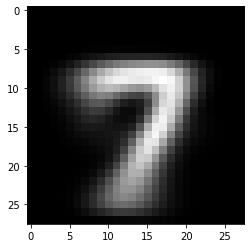

In [12]:
mean_7 = jnp.mean(stacked_sevens, axis=0)
plt.imshow(mean_7)

In [13]:
def mnist_distance(a: jnp.ndarray, b: jnp.ndarray):
    return jnp.mean(jnp.abs(a - b), axis=(-2, -1))

In [14]:
example_3 = stacked_threes[0]

In [15]:
mnist_distance(example_3, mean_3), mnist_distance(example_3, mean_7)

(DeviceArray(0.15338802, dtype=float32),
 DeviceArray(0.20392026, dtype=float32))

In [17]:
valid_3_to_3 = mnist_distance(valid_3s, mean_3)
valid_3_to_7 = mnist_distance(valid_3s, mean_7)
valid_7_to_3 = mnist_distance(valid_7s, mean_3)
valid_7_to_7 = mnist_distance(valid_7s, mean_7)

How many 3s are detected as 3?

In [18]:
percision_3 = jnp.sum(valid_3_to_3 < valid_3_to_7) / valid_3s.shape[0]
percision_3

DeviceArray(0.9168317, dtype=float32)

In [20]:
percision_7 = jnp.sum(valid_7_to_7 < valid_7_to_3) / valid_7s.shape[0]
percision_7

DeviceArray(0.98540854, dtype=float32)

In [21]:
(percision_3 + percision_7) / 2

DeviceArray(0.95112014, dtype=float32)

When a image is claimed as 3, how much chance will it be accually 3?

In [22]:
recall_3 = (
    percision_3
    * valid_3s.shape[0]
    / (percision_3 * valid_3s.shape[0] + (1 - percision_7) * valid_7s.shape[0])
)
recall_3

DeviceArray(0.9840595, dtype=float32)

### SGD

In [14]:
train_x = jnp.reshape(jnp.concatenate([stacked_threes, stacked_sevens]), (-1, 28 * 28))
train_y = jnp.expand_dims(
    jnp.concatenate(
        [
            jnp.ones(stacked_threes.shape[0]),
            jnp.zeros(stacked_sevens.shape[0]),
        ]
    ),
    axis=1,
)
train_x.shape, train_y.shape

((12396, 784), (12396, 1))

In [48]:
key = jax.random.PRNGKey(42)

In [49]:
def init_params(key, shape, std=1.0):
    return jax.random.normal(key, shape) * std

In [50]:
key, subkey = jax.random.split(key)
weights = init_params(subkey, (28 * 28, 1))

In [51]:
key, subkey = jax.random.split(key)
bias = init_params(subkey, (1,))

In [52]:
jnp.sum(weights.T * train_x[0]) + bias

DeviceArray([-2.1525104], dtype=float32)

In [53]:
train_x.shape, weights.shape

((12396, 784), (784, 1))

In [54]:
def linear1(xb):
    return xb @ weights + bias

In [55]:
pred = linear1(train_x)
pred

DeviceArray([[ -2.1525085],
             [ -8.7244425],
             [-19.967657 ],
             ...,
             [ -4.52095  ],
             [ -8.558947 ],
             [ -5.6343822]], dtype=float32)

In [56]:
corrects = (pred > 0) == train_y
jnp.mean(corrects)

DeviceArray(0.51637626, dtype=float32)

The problem is that a small change in weights from `x_old` to `x_new` isn’t likely to cause any prediction to change, so `(y_new – y_old)` will almost always be 0. In other words, the gradient is 0 almost everywhere.

Let's find the weight which is the most important

In [66]:
significant_index = jnp.argmax(jnp.mean(train_x, axis=0)).item()

In [60]:
weights = weights.at[significant_index].multiply(1.0001)
jnp.mean((linear1(train_x) > 0) == train_y)

DeviceArray(0.51637626, dtype=float32)

A very small change in the value of a weight will often not change the accuracy at all.
This means it is not useful to use accuracy as a loss function.

We choose the (vector) distance between the true value and the prediction.

```python
trgts = tensor([1,0,1])
prds = tensor([0.9, 0.4, 0.2])
```

In [61]:
def mnist_loss(predictions, targets):
    return jnp.mean((predictions - targets) ** 2)

In [62]:
mnist_loss(pred, train_y)

DeviceArray(126.34416, dtype=float32)

In [63]:
mnist_loss(linear1(train_x), train_y)

DeviceArray(126.34432, dtype=float32)